# Train a signle job

In [1]:
import pandas as pd

file_path = 'data/one_job_run.csv'
date_columns = ['CREATE_TS', 'STATUS_UPDATE_TS']
job_runs = pd.read_csv(
    file_path, 
    parse_dates=date_columns
)

job_runs.head()

,JOB_NAME,PROCESS_RUN_SK,BATCH_SK,CREATE_TS,STATUS_UPDATE_TS,ROWS_ADDED_COUNT,ROWS_UPDATED_COUNT,ROWS_DELETED_COUNT,ROWS_DUPLICATED_COUNT,ROWS_SKIPPED_COUNT,ROWS_ERROR_COUNT
0,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3405542652,1070043000,2023-12-17 00:02:06+00:00,2023-12-17 00:11:31+00:00,1392,-1,-1,-1,-1,-1
1,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3405544370,1070043860,2023-12-17 00:16:26+00:00,2023-12-17 00:20:30+00:00,1115,-1,-1,-1,-1,-1
2,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3405546256,1070044803,2023-12-17 00:32:09+00:00,2023-12-17 00:36:01+00:00,4098,-1,-1,-1,-1,-1
3,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3405548068,1070045709,2023-12-17 00:47:15+00:00,2023-12-17 00:49:54+00:00,3650,-1,-1,-1,-1,-1
4,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3405549944,1070046647,2023-12-17 01:02:53+00:00,2023-12-17 01:09:16+00:00,1145,-1,-1,-1,-1,-1


In [2]:
# Replace all -1 to 0
X = job_runs.replace({-1: 0})

X['TOTAL_ROWS'] = (
    X['ROWS_ADDED_COUNT'] + 
    X['ROWS_UPDATED_COUNT'] + 
    X['ROWS_UPDATED_COUNT'] + 
    X['ROWS_DELETED_COUNT'] + 
    X['ROWS_DUPLICATED_COUNT'] + 
    X['ROWS_SKIPPED_COUNT'] + 	
    X['ROWS_ERROR_COUNT']
)

In [3]:
# Remove empty runs
X = X[X['TOTAL_ROWS'] > 0]

In [4]:
# Add duration column
X['DURATION'] = (X['STATUS_UPDATE_TS'] - X['CREATE_TS']).map(lambda delt: delt.total_seconds())

In [5]:
# # set index to timestamp
# X.set_index('CREATE_TS', inplace=True)


In [6]:
X.head()

,JOB_NAME,PROCESS_RUN_SK,BATCH_SK,CREATE_TS,STATUS_UPDATE_TS,ROWS_ADDED_COUNT,ROWS_UPDATED_COUNT,ROWS_DELETED_COUNT,ROWS_DUPLICATED_COUNT,ROWS_SKIPPED_COUNT,ROWS_ERROR_COUNT,TOTAL_ROWS,DURATION
0,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3405542652,1070043000,2023-12-17 00:02:06+00:00,2023-12-17 00:11:31+00:00,1392,0,0,0,0,0,1392,565.0
1,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3405544370,1070043860,2023-12-17 00:16:26+00:00,2023-12-17 00:20:30+00:00,1115,0,0,0,0,0,1115,244.0
2,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3405546256,1070044803,2023-12-17 00:32:09+00:00,2023-12-17 00:36:01+00:00,4098,0,0,0,0,0,4098,232.0
3,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3405548068,1070045709,2023-12-17 00:47:15+00:00,2023-12-17 00:49:54+00:00,3650,0,0,0,0,0,3650,159.0
4,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3405549944,1070046647,2023-12-17 01:02:53+00:00,2023-12-17 01:09:16+00:00,1145,0,0,0,0,0,1145,383.0


In [7]:
# Aggregate 

# Define dictionary mapping columns to aggregate functions
agg_mapping = {'CREATE_TS': 'min', 'TOTAL_ROWS': 'sum', 'DURATION': 'mean'}
X_agg = X.groupby(['JOB_NAME', 'PROCESS_RUN_SK']).agg(agg_mapping)

In [8]:
X_agg['TIME'] = X_agg['CREATE_TS'].astype(int)
X_agg.set_index('TIME')

,CREATE_TS,TOTAL_ROWS,DURATION
TIME,,,
1702771326000000000,2023-12-17 00:02:06+00:00,1392,565.0
1702772186000000000,2023-12-17 00:16:26+00:00,1115,244.0
1702773129000000000,2023-12-17 00:32:09+00:00,4098,232.0
1702774035000000000,2023-12-17 00:47:15+00:00,3650,159.0
1702774973000000000,2023-12-17 01:02:53+00:00,1145,383.0
...,...,...,...
1708033641000000000,2024-02-15 21:47:21+00:00,32603,172.0
1708034551000000000,2024-02-15 22:02:31+00:00,2093,396.0
1708035452000000000,2024-02-15 22:17:32+00:00,1510,247.0


In [40]:
X_agg_reindex = X_agg.reset_index()
# X_train = X_agg[:, ['TIME', 'TOTAL_ROWS', 'DURATION']]
X_agg_reindex

,JOB_NAME,PROCESS_RUN_SK,CREATE_TS,TOTAL_ROWS,DURATION,TIME
0,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3405542652,2023-12-17 00:02:06+00:00,1392,565.0,1702771326000000000
1,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3405544370,2023-12-17 00:16:26+00:00,1115,244.0,1702772186000000000
2,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3405546256,2023-12-17 00:32:09+00:00,4098,232.0,1702773129000000000
3,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3405548068,2023-12-17 00:47:15+00:00,3650,159.0,1702774035000000000
4,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3405549944,2023-12-17 01:02:53+00:00,1145,383.0,1702774973000000000
...,...,...,...,...,...,...
5757,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3416067280,2024-02-15 21:47:21+00:00,32603,172.0,1708033641000000000
5758,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3416069100,2024-02-15 22:02:31+00:00,2093,396.0,1708034551000000000
5759,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3416070904,2024-02-15 22:17:32+00:00,1510,247.0,1708035452000000000
5760,EXT_HANA_SEMS_ISSUE_TXN--GENERIC,3416072592,2024-02-15 22:31:36+00:00,1404,286.0,1708036296000000000


In [41]:
# X_train 'PROCESS_RUN_SK', 'TIME', 
X_train = X_agg_reindex.loc[:, ['TOTAL_ROWS', 'DURATION']]

In [48]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
import numpy as np

                                                    
# Create and train the OCSVM model
ocsvm = OneClassSVM(kernel='rbf', nu=0.001)

ocsvm.fit(X_train)

# Predict anomalies (1 for normal instances, -1 for anomalies)
predictions = ocsvm.predict(X_train)

# Print predictions
print("Predictions:", predictions)

Predictions: [1 1 1 ... 1 1 1]


In [49]:
y_pred = pd.Series(predictions, name='pred')

In [45]:
# display(X_train)
# display(y_pred)
X_agg_reindex['pred'] = y_pred

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

<Axes: xlabel='CREATE_TS', ylabel='TOTAL_ROWS'>

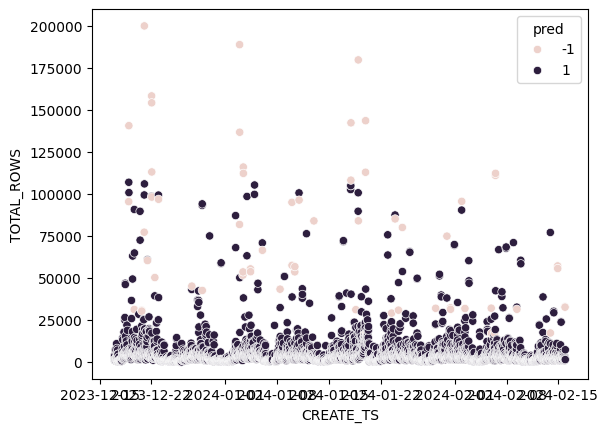

In [50]:
sns.scatterplot(
    data=X_agg_reindex,
    x='CREATE_TS', 
    y='TOTAL_ROWS',
    hue="pred",   # map smoker value to the color of the points
)

<Axes: >

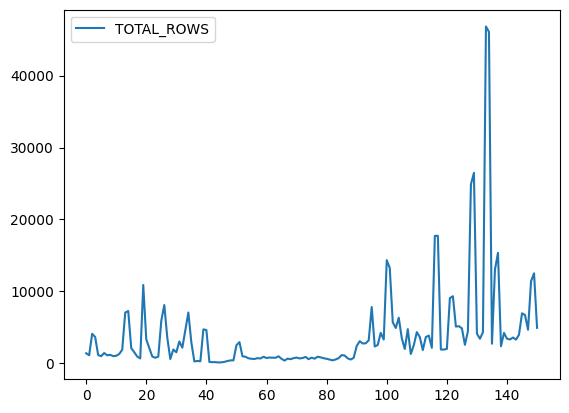

In [75]:
# sns.lineplot(data=X_agg_reindex['TOTAL_ROWS'])
sns.lineplot(data=X_agg_reindex.loc[:150, ['TOTAL_ROWS']])

<Axes: >

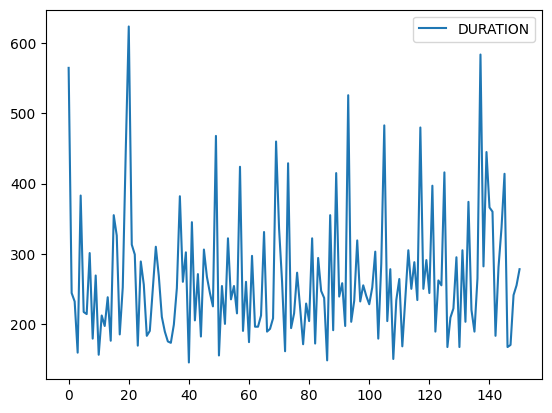

In [76]:
sns.lineplot(data=X_agg_reindex.loc[:150, ['DURATION']])

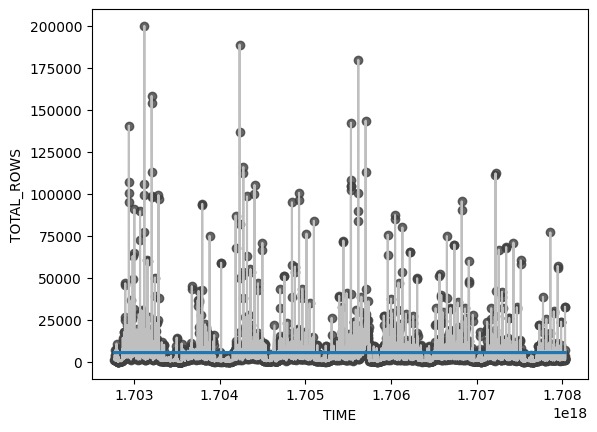

In [56]:
fig, ax = plt.subplots()
ax.plot('TIME', 'TOTAL_ROWS', data=X_agg_reindex, color='0.75')
ax = sns.regplot(x='TIME', y='TOTAL_ROWS', data=X_agg_reindex, ci=None, scatter_kws=dict(color='0.25'))

In [3]:
a3_secrets = {
    "dev": {
        "app_id": "000",
        "app_password": "Apple"
    },
    "uat": {
        "app_id": "123",
        "app_password": "hello"
    },
    "prod": {
        "app_id": "456",
        "app_password": "world"
    }
}

In [4]:
my_dict = {
    env.lower(): idms_dict
    for env, idms_dict in a3_secrets.items()
    if env.lower() in ('uat', 'prod')
}
print(my_dict)

{'uat': {'app_id': '123', 'app_password': 'hello'}, 'prod': {'app_id': '456', 'app_password': 'world'}}


In [5]:
for env in a3_secrets:
    print(env)

dev
uat
prod


In [19]:
prod_dict = [v for v in a3_secrets['prod'].values()]
print(prod_dict)

['456', 'world']


In [13]:
kwargs = {'a': 'test', 'b': 'me'}
my_dict.update(kwargs)

print(my_dict)

{'uat': {'app_id': '123', 'app_password': 'hello'}, 'prod': {'app_id': '456', 'app_password': 'world'}, 'a': 'test', 'b': 'me'}


In [16]:
my_list = [1, 2, 3]
other_list = [4, 5, 6]
my_list.extend(other_list)
print(my_list)

[1, 2, 3, 4, 5, 6]
